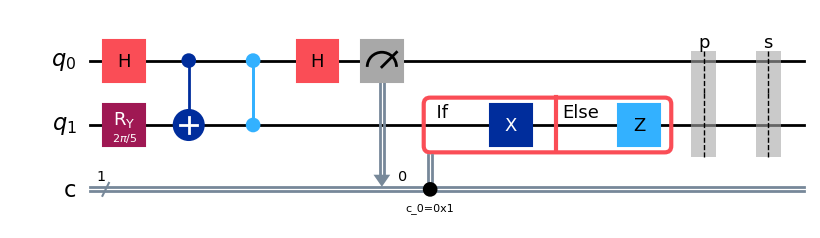

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import partial_trace, state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.classical import expr
from qiskit.visualization import plot_histogram
import numpy as np

#Construct circuit for implementing a Hadamard gate through the use of an ancilla
qc = QuantumCircuit(2, 1)
qc.ry(2 * np.pi / 5, 1)  #Not part of the circuit. Just to prepare a state other than |0> or |1>
qc.h(0)
qc.cx(0,1)
qc.cz(0,1)
qc.h(0)
qc.measure(0,0)

#Corrections to apply based on ancilla measurement
with qc.if_test((qc.clbits[0], 1)) as else_:
    qc.x(1)
with else_:
    qc.z(1)

qc.save_density_matrix(label='p')
qc.save_statevector(label='s')


simulator = AerSimulator()
qct = transpile(qc, backend=simulator)
result = simulator.run(qct, shots=1, memory=True).result()
density_matrix = result.data()['p']
reduced_matrix = partial_trace(density_matrix, [0])
reduced_matrix.draw(output='latex')

qc.draw('mpl')

In [2]:
#Density matrix for using the method on a physical qubit
result.data()['s'].draw(output='latex')
reduced_matrix.draw(output='latex')

<IPython.core.display.Latex object>

In [3]:
#Creates a reference density matrix for a normal hadamard on a single physical qubit
qc_ref = QuantumCircuit(1)
qc_ref.ry(2 * np.pi / 5, 0) #Use same state preparation
qc_ref.h(0) #Physical H gate
qc_ref.save_density_matrix(label='p')
qc_ref.save_statevector(label='s')
simulator = AerSimulator()
qc_reft = transpile(qc_ref, backend=simulator)
result = simulator.run(qc_reft, shots=1, memory=True).result()
density_matrix = result.data()['p']
density_matrix.draw(output='latex')
# state_vec = result.data()['s']
# state_vec.draw(output='latex')

<IPython.core.display.Latex object>

In [ ]:
#Logical Steane Code methods used for testing the ancilla method

#Creates the circuit with the necessary registers and data
def generate_circuit():
    log_qreg = QuantumRegister(7, 'q')
    anc_qreg = AncillaRegister(1, 'a')
    log_creg = ClassicalRegister(7, 'lc')
    anc_creg = ClassicalRegister(1, 'ac')
    output_creg = ClassicalRegister(1, 'oc')
    circ = QuantumCircuit(log_qreg, anc_qreg, anc_creg, log_creg, output_creg)

    #Encoding circuit
    circ.h(log_qreg[0])
    circ.h(log_qreg[4])
    circ.h(log_qreg[6])
    circ.cx(log_qreg[0], log_qreg[1])
    circ.cx(log_qreg[4], log_qreg[5])
    circ.cx(log_qreg[6], log_qreg[3])
    circ.cx(log_qreg[4], log_qreg[2])
    circ.cx(log_qreg[6], log_qreg[5])
    circ.cx(log_qreg[0], log_qreg[3])
    circ.cx(log_qreg[4], log_qreg[1])
    circ.cx(log_qreg[3], log_qreg[2])
    circ.barrier()

    return circ

#Uses a transversal hadamard on a logical qubit
def trans_logical_h(circ):
    for i in range(len(circ.qregs[0])):
        circ.h(i)
    circ.barrier()

#Uses the ancilla method to implement a logical hadamard gate
def anc_logical_h(circ):
    circ.h(circ.ancillas[0])
    ancilla_cx(circ)
    ancilla_cz(circ)
    circ.h(circ.ancillas[0])
    circ.measure(circ.ancillas[0], 0)

    with circ.if_test((circ.clbits[0], 1)) as else_:
        logical_x(circ)
    with else_:
        logical_z(circ)

    circ.reset(circ.ancillas[0])

def logical_x(circ):
    circ.x(4)
    circ.x(5)
    circ.x(6)
    circ.barrier()

def logical_z(circ):
    circ.z(4)
    circ.z(5)
    circ.z(6)
    circ.barrier()

#Implements a logical X gate with the ancilla qubit as the control
def ancilla_cx(circ):
    circ.cx(circ.ancillas[0], 4)
    circ.cx(circ.ancillas[0], 5)
    circ.cx(circ.ancillas[0], 6)
    circ.barrier()

#Implements a logical Z gate with the ancilla qubit as the control
def ancilla_cz(circ):
    circ.cz(circ.ancillas[0], 4)
    circ.cz(circ.ancillas[0], 5)
    circ.cz(circ.ancillas[0], 6)
    circ.barrier()

#Measures the logical state of the qubit
def measure(circ):
    for i in range(len(circ.qregs[0])):
        circ.measure(i, circ.cregs[1][i])
    with circ.if_test(cbit_xor([circ.cregs[1][x] for x in [4,5,6]])):
            circ.x(circ.ancillas[0])
            circ.measure(circ.ancillas[0], circ.cregs[2][0])

#Copied from Logical.py and used for logical measurement
def cbit_xor(cbits):
    result = expr.lift(cbits[0])
    for n in range(len(cbits)-1):
        result = expr.bit_xor(result, cbits[n+1])
    return result

#Puts the logical outputs into a dict format to be plotted
def get_logical_counts(output):
    counts = {}
    counts['0'] = 0
    counts['1'] = 0
    for o in output:
        if o[0] == '1':
            counts['1'] += 1
        if o[0] == '0':
            counts['0'] += 1

    return counts


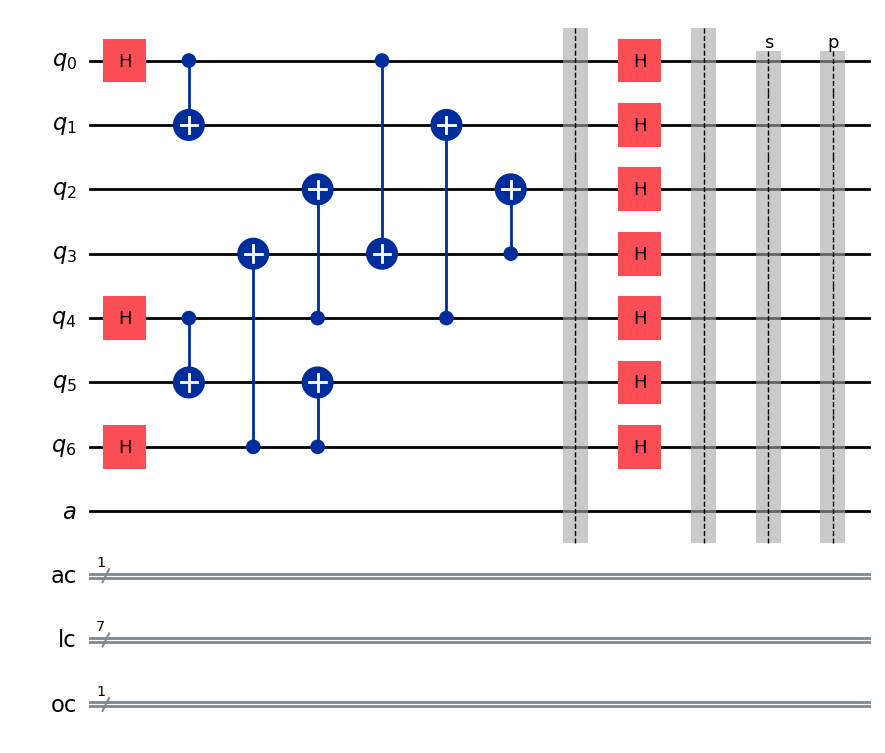

In [ ]:
#Creates a transveral H gate
steane_circ = generate_circuit()
trans_logical_h(steane_circ)
steane_circ.save_statevector(label='s')
steane_circ.save_density_matrix(label='p')
steane_circ.draw('mpl', style='iqp')

In [ ]:
#Calculates the density matrix
simulator = AerSimulator()
qct = transpile(steane_circ, backend=simulator)
result = simulator.run(qct, shots=1, memory=True).result()
density_matrix = result.data()['p']
trans_h_matrix = partial_trace(density_matrix, [7])
trans_h_matrix.draw(output='latex')

<IPython.core.display.Latex object>

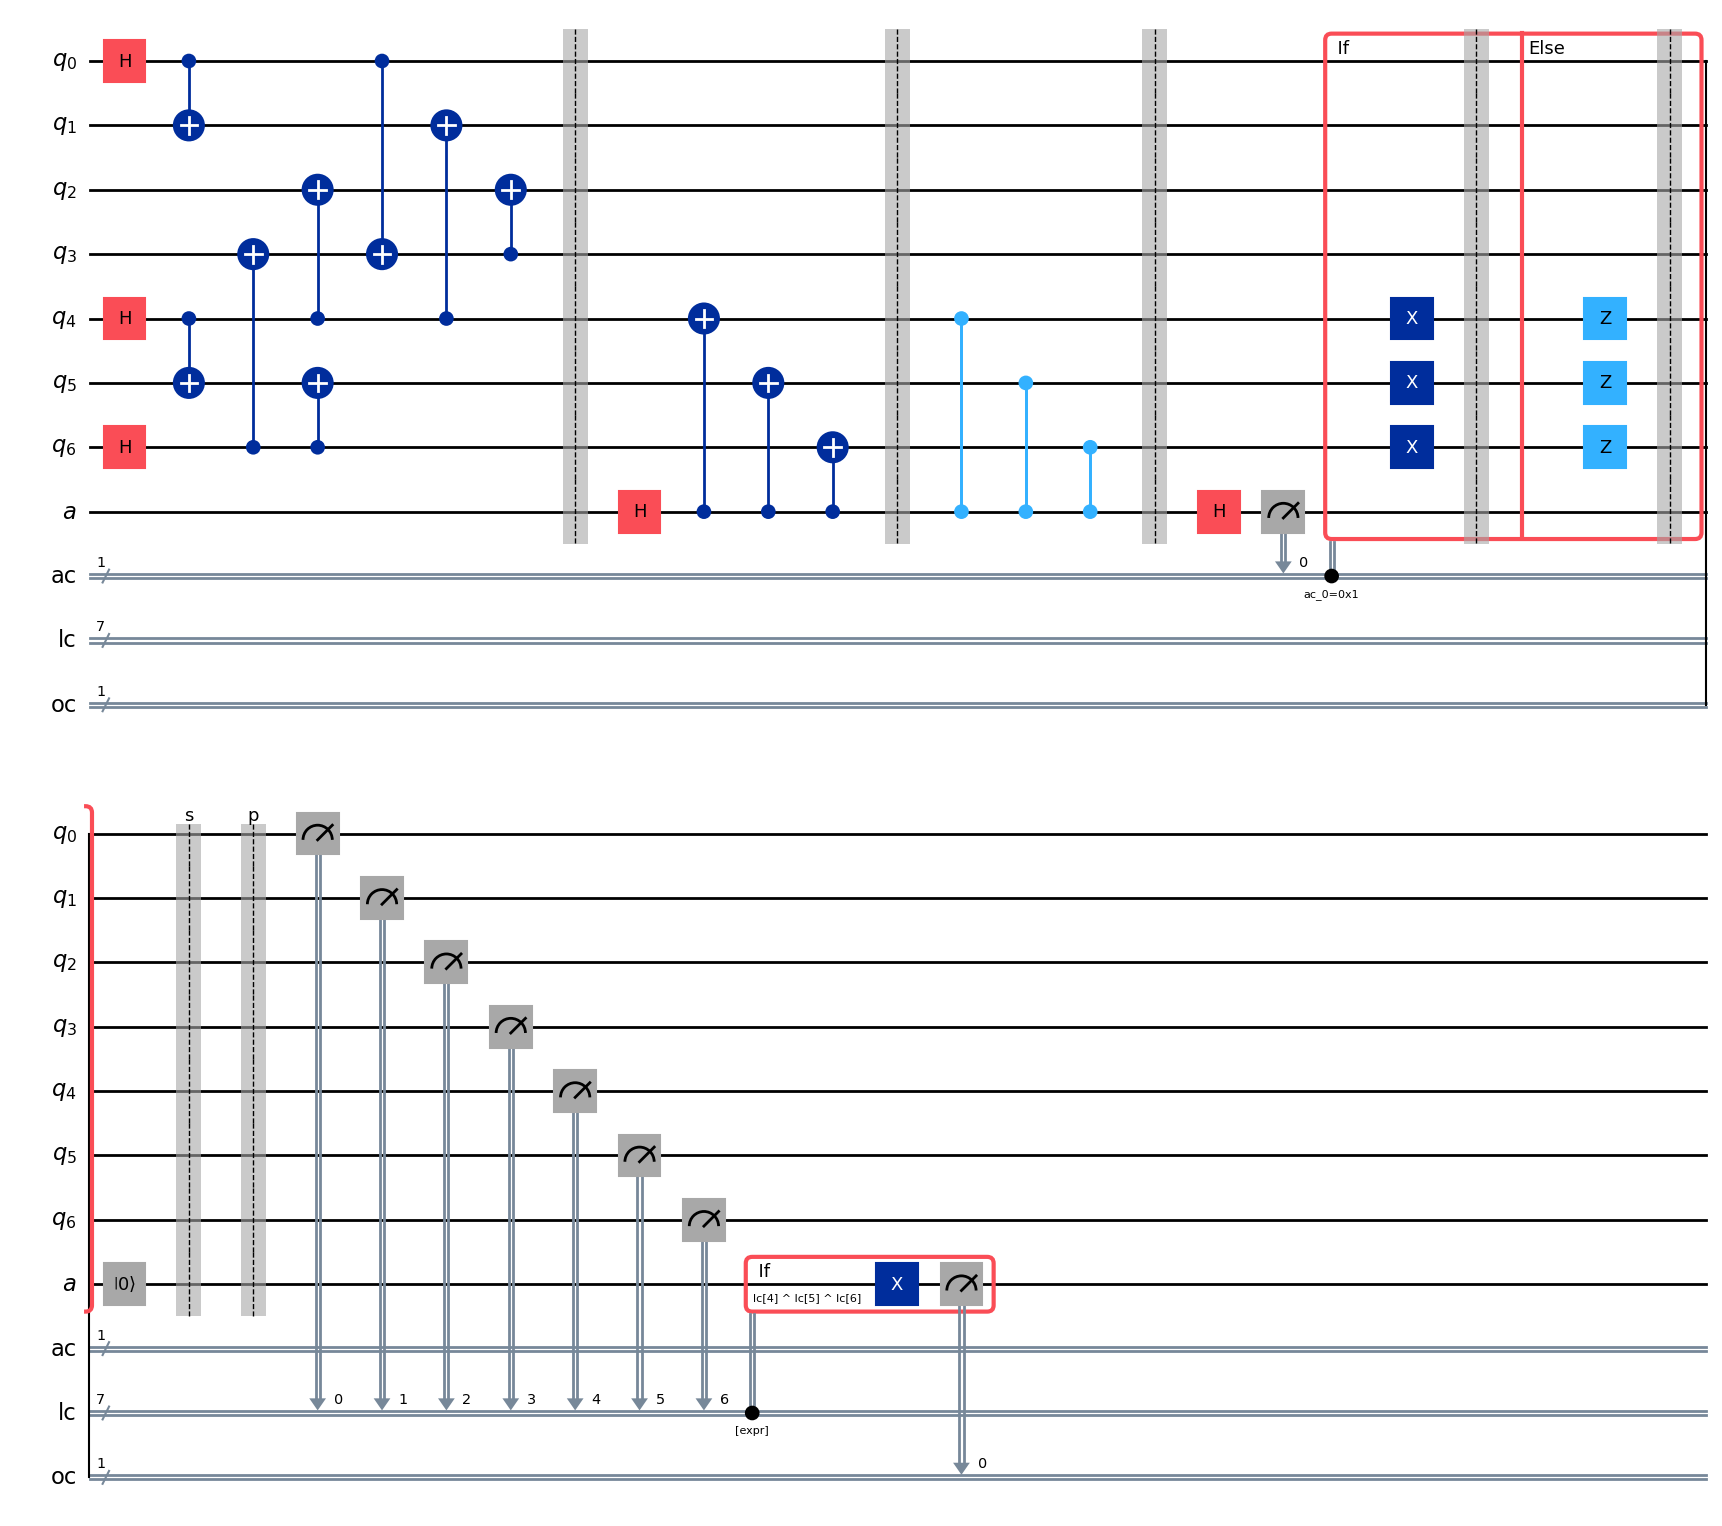

In [ ]:
#Creates an ancilla assisted H gate
steane_circ = generate_circuit()
anc_logical_h(steane_circ)
steane_circ.save_statevector(label='s')
steane_circ.save_density_matrix(label='p')
measure(steane_circ)
steane_circ.draw('mpl', style='iqp')

In [ ]:
#Calculates the density matrix
simulator = AerSimulator()
qct = transpile(steane_circ, backend=simulator)
result = simulator.run(qct, shots=1, memory=True).result()
density_matrix = result.data()['p']
anc_h_matrix = partial_trace(density_matrix, [7])
anc_h_matrix.draw(output='latex')

<IPython.core.display.Latex object>

In [ ]:
#Calculates the fidelity between the two methods
print(state_fidelity(trans_h_matrix, anc_h_matrix))

1.0000000000000235


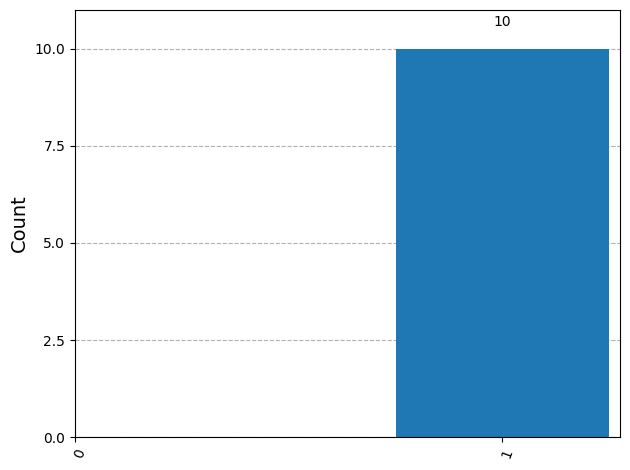

In [ ]:
#Tests a random circuit to make sure the ancilla assisted method functions as a true logical Hadamard
steane_circ = generate_circuit()
anc_logical_h(steane_circ)
logical_z(steane_circ)
anc_logical_h(steane_circ)
measure(steane_circ)

simulator = AerSimulator()
qct = transpile(steane_circ, backend=simulator)
result = simulator.run(qct, shots=1000, memory=True).result()
output = result.get_memory(qct)
counts = get_logical_counts(output)
plot_histogram(counts)
